In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools
from pygam import LinearGAM
import subprocess
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import anova

In [2]:
# set results path
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev'
index = 't1wT2wRatio'  

In [3]:
# get cerebellum mask
atlas_dir = os.path.join(os.getcwd(), 'atlas')
atlas_mni_path = os.path.join(atlas_dir, 'MNI152_T1_2mm_brain.nii.gz')
cb_mask_mni_path = os.path.join(atlas_dir,'Cerebellum-MNIfnirt-maxprob-thr25.nii')
cb_mask_fslr_path = os.path.join(atlas_dir,  'Cerebellum-MNIfnirt-maxprob-thr25.dscalar.nii')

cb_mask = nib.load(cb_mask_mni_path).get_fdata()
cb_mask[cb_mask!=0] = 1
cb_mask = np.asarray(cb_mask,dtype=np.bool)

In [4]:
# data prepare
index_dir = os.path.join(results_dir, index)
sub_adult = pd.read_csv(os.path.join(results_dir, 'sub_adult'), header=0, dtype={'Sub': np.str})
sub_dev = pd.read_csv(os.path.join(results_dir, 'sub_dev'), header=0, dtype={'Sub': np.str})
num_str_col = 6

In [5]:
# prepare roi data
atlas_cb = {'t1wT2wRatio' : 'cb_anat_fsl', 'fALFF' : 'cb_anat_cifti'}
atlas = cb_tools.atlas_load(atlas_cb[index], atlas_dir)
data_roi = pd.read_csv(os.path.join(index_dir, f'{index}_{atlas_cb[index]}.csv'))
data_roi = data_roi.astype({'Sub': np.str})
data_adult_roi = data_roi.merge(sub_adult, on='Sub', how='inner')
data_dev_roi = data_roi.merge(sub_dev, on='Sub', how='inner')

In [7]:
# prepare voxel data
if index == 't1wT2wRatio':
    data_adult_voxel = nib.load(os.path.join(index_dir, 'HCP-Adult', f'{index}_cb_voxel_mean.nii.gz')).get_fdata()
elif index == 'fALFF':
    data_adult_voxel = nib.load(os.path.join(index_dir, 'HCP-Adult', f'{index}_cb_voxel_mean_cbonly_onlylobues.nii.gz')).get_fdata()
data_dev_voxel = pd.read_csv(os.path.join(index_dir, f'{index}_cb_voxel.csv'))

data_adult_voxel[~cb_mask] = 0

# prepare palette
palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=len(atlas.label_info['lobule'][:18:2]))

In [10]:
# roi results
def hemi_merging(x, num_str_col):
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: x.split('_')[0], inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: x.split('_')[0], inplace=True)

    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0),x.iloc[:,-num_str_col:]], axis=1)
    
    return x_merged

dev = hemi_merging(data_dev_roi, num_str_col)
adult = hemi_merging(data_adult_roi, num_str_col)
lobule_name = atlas.label_info['lobule'][:18:2]

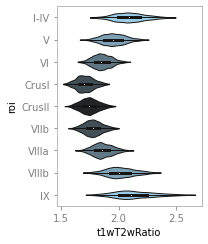

In [12]:
# Fig. 1c
# violin plot of cb lobules
data = copy.deepcopy(adult)

# threshold
data.loc[:,data.columns[:-num_str_col]] = cb_tools.thr_IQR(
    data.loc[:,data.columns[:-num_str_col]].values, times=1.5, series=True)  # remove outliers outside 1.5 IQR
data = data.dropna()

# data stack
data_stack = pd.melt(data, id_vars=data.columns[-num_str_col:], 
                     var_name=['lobule'], value_vars=data.columns[:-num_str_col], value_name=index)
data_stack = pd.concat([data_stack, data_stack['lobule'].str.split('_',expand=True).rename(columns={0:'roi',1:'hemi'})], axis=1)

# plot
row = 'roi'
value = index
row_order = atlas.label_info['lobule'][:18:2]

fig, ax = plt.subplots(figsize=(3, 3.5))
sns.violinplot(x=value, y=row, palette=palette_cb, order=row_order, fliersize=1,
                    cut=0, bw=.2, whis=3, linewidth=1, data=data_stack, ax=ax)

ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
plt.tight_layout()

# stats
gradient_stats = anova.AnovaRM(data=data_stack, depvar=index, subject='Sub', within=['roi']).fit()

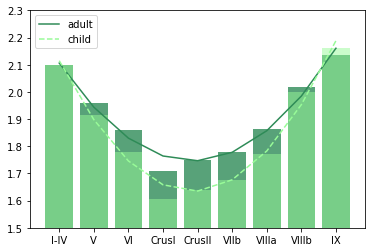

In [14]:
# Fig 1e
# average gradient in children and adults groups
dev_child = dev[dev['Age_in_years']<20]
dev_mean = np.nanmean(cb_tools.thr_IQR(dev_child.loc[:,dev_child.columns[:-num_str_col]].values, times=1.5, series=True), 0)
adult_mean = np.nanmean(cb_tools.thr_IQR(adult.loc[:,adult.columns[:-num_str_col]].values, times=1.5, series=True), 0)

# quantratic fit
x = np.arange(adult_mean.shape[0]) - (adult_mean.shape[0]-1)/2
adult_coef = np.polyfit(x, adult_mean, deg=2)
adult_y_fit = np.polyval(adult_coef, x)
dev_coef = np.polyfit(x, dev_mean, deg=2)
dev_y_fit = np.polyval(dev_coef, x)

# plot
plt.plot(lobule_name, adult_y_fit, c='seagreen', label='adult')
plt.bar(lobule_name, adult_mean, color='seagreen', alpha=0.8)
plt.plot(lobule_name, dev_y_fit, c='palegreen', ls='--', label='child')
plt.bar(lobule_name, dev_mean, color='palegreen', alpha=0.5)
if index == 't1wT2wRatio':
    plt.ylim([1.5, 2.3])
elif index == 'fALFF':
    plt.ylim([0.08, 0.16])
plt.legend()

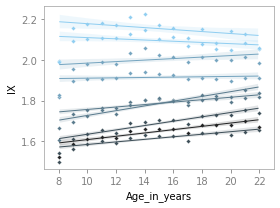

In [16]:
# %% Fig 1f
# dev trojetory for each lobule
data = copy.deepcopy(dev)
data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values, times=1.5, series=True)
data_g = data.groupby(['Age_in_years']).mean().loc[:, data.columns[:-num_str_col]]

# data stack
data_stack = pd.melt(data, id_vars=data.columns[-num_str_col:], 
                     var_name=['lobule'], value_vars=data.columns[:-num_str_col], value_name=index)
data_stack = pd.concat([data_stack, data_stack['lobule'].str.split('_',expand=True).rename(columns={0:'roi',1:'hemi'})], axis=1)

# plot
sns.set_palette(palette_cb)
_, ax = plt.subplots(figsize=[4,3])   
[sns.regplot(x=data['Age_in_months'] / 12, y=data[i], scatter=False, line_kws={'lw':1}) for i in data.columns[:-num_str_col]]
[sns.scatterplot(x=data_g.index, y=data_g[i], s=10, marker='D') for i in data_g.columns]

ax.set_xlim([7,23])
ax.set_xticks(np.arange(8, 23, 2))
if index == 't1wT2wRatio':
    ax.set_yticks(np.arange(1.6, 2.3, 0.2))
elif index == 'fALFF':
    ax.set_yticks(np.arange(0.1, 0.16, 0.02))
ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
ax.set_xlabel('Age_in_years')
plt.tight_layout()

# stats
model = ols(f'{index} ~ C(Age_groups)*C(roi)', data=data_stack).fit()

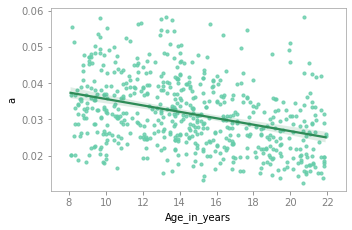

In [19]:
# %% Fig 1h
# dev trojetory of curvature
# quantratic fit
def gradient_magnitude(x):
    polyfit = np.asarray([np.polyfit(np.arange(x.shape[-1]) - (x.shape[-1]-1)/2, 
                                     x.iloc[i, :].to_numpy(dtype=float), deg=2) for i in range(x.shape[0])])
    polyfit_df = pd.DataFrame(polyfit, columns=['a','b','c'])
    polyfit_df['p1'] = -polyfit_df['b']/(2*polyfit_df['a'])
    
    return polyfit_df

# get curvature
data = copy.deepcopy(dev)

shape = gradient_magnitude(data.iloc[:,:-num_str_col])
shape = pd.concat((shape, data.iloc[:,-num_str_col:]), axis=1)

data = copy.deepcopy(shape)
data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values, times=1.5, series=True) # remove outliers
data.dropna(inplace=True)
data_g = data.groupby(['Age_in_years']).mean().loc[:, data.columns[:-num_str_col]]

# plot dev trajactory - linear model
x = 'Age_in_months'
y = 'a'
_, ax = plt.subplots(figsize=[5,3.3])    
sns.regplot(x=data[x]/12, y=data[y], color='seagreen', ax=ax, scatter_kws={'s':10, 'color':'mediumaquamarine'})
ax.set_xticks(np.arange(8, 23, 2))
ax.set_xlim([7,23])
ax.set_xlabel('Age_in_years')
ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
plt.tight_layout()

# stats
model = ols('a ~ Age_in_months', data=data).fit()

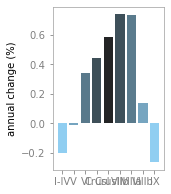

In [20]:
# Fig 1g
# k 
def linear_fit(data, num_str_col):
    
    data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values.T, times=1.5, series=True).T
    nan_voxel = np.isnan(data[data.columns[:-num_str_col]]).sum(0)>len(data)*0.3
    data.loc[:, np.r_[nan_voxel, np.zeros(num_str_col).astype(np.bool)]] = 0
    
    x = 'Age_in_months'
    y = data.columns[:-num_str_col]
    
    order = 1
    polyfit = np.asarray([np.polyfit(data.loc[~np.isnan(data[y_i]), x] / 12, data.loc[~np.isnan(data[y_i]), y_i], deg=order) for y_i in y])
    polyfit[np.isnan(data[data.columns[:-num_str_col]]).sum(0)>(len(data)*0.3-num_str_col)] = np.nan
    polyfit_df = pd.DataFrame(polyfit, columns=['k','b'])
    
    return polyfit_df

data = copy.deepcopy(dev)
linear_coef = linear_fit(data, num_str_col)
k = linear_coef['k']
pct = linear_coef['k'] / linear_coef['b'] * 100

# plot
_, ax = plt.subplots(figsize=[2,3])
ax.bar(lobule_name, pct, color=palette_cb)
ax.set_ylabel('annual change (%)')
ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]

# stats
# linear regression
stats_results = pd.DataFrame(data.columns[:-num_str_col].values, columns=['lobule'])
for lobule in stats_results['lobule']:
    X = data['Age_in_months'] / 12
    y = data[lobule]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    fit = model.fit()
    
    stats_results.loc[stats_results['lobule']==lobule, ['coef', 'R2-adj', 'F', 'p']] = [
        fit.params[-1], fit.rsquared_adj, fit.fvalue, fit.f_pvalue]   

In [ ]:
# %% Fig 1i
# save nifti files, plot by SUIT in matlab
data = copy.deepcopy(data_dev_voxel)
linear_coef = linear_fit(data, num_str_col)
k = linear_coef['k']
pct = linear_coef['k'] / linear_coef['b'] *100

to_save = {'k':k, 'pct':pct}

if index == 't1wT2wRatio':
    # save nii
    for key in to_save.keys():
        polyfit_img = np.zeros(cb_mask.shape)
        polyfit_img[cb_mask] = to_save[key]
        
        save_path = os.path.join(index_dir, f'{index}_cb_voxel_dev_{key}.nii.gz')
        img = nib.Nifti1Image(polyfit_img, None)
        nib.save(img, save_path)
        subprocess.call(f'fslcpgeom {cb_mask_mni_path} {save_path} -d', shell=True)
    
elif index == 'fALFF':
    # save nii
    for key in to_save.keys():
        brain_models = cb_tools.CiftiReader(cb_mask_fslr_path).brain_models()   
        polyfit_img = to_save[key]
        save_path = os.path.join(index_dir, f'{index}_cb_voxel_dev_{key}.dscalar.nii')
        cb_tools.save2cifti(save_path, polyfit_img[None,...], brain_models, volume=cb_tools.CiftiReader(cb_mask_fslr_path).volume)
        subprocess.check_output('wb_command -cifti-separate {0}.dscalar.nii COLUMN -volume-all {0}.nii.gz'.format(save_path.split('.')[0]), shell=True)

# =======================
# plot by suit in matlab
# =======================